In [81]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import time
import datetime as dt 
import yfinance as yf
import cvxpy as cvx
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import alphalens as al
import warnings
from abc import ABC, abstractmethod

from functions.datareader import pull_stock_data, YFinanceReader

warnings.filterwarnings('ignore')

<h1 style="color:orange">Load data using YFinance and save to local</h1>

In [2]:
# source for yfinance: https://pypi.org/project/yfinance/
start = dt.date(2019, 1, 1)
end = dt.date(2022, 4, 1)

# * parameters
ANNUALIZATION_FACTOR = 252

In [3]:
sectors = {
    'banking': ['BBL', 'KBANK', 'SCB', 'BAY', 'TISCO', 'KTB', 'KKP', 'TTB'],
    'hospital': ['BDMS', 'BCH', 'BH', 'THG', 'PR9', 'EKH', 'IMH', 'RJH', 'RPH', 'MEGA', 'KLINIQ'],
    'infrastructure': ['AOT', 'BAFS', 'BEM', 'DMT'],
    'consumer_staple': ['BJC', 'OR', 'CPALL', 'CRC', 'MAJOR', 'GFPT', 'CPF', 'MAKRO', 'M', 'TU', 'TC'],
    'consumer_discretionary': ['COM7', 'CPW', 'SYNEX', 'JUBILE', 'CPH'],
    'technology': ['BBIK', 'IIG', 'BE8'],
    'industrial': ['WHA', 'AMATA'],
    'material': ['SCGP', 'HMPRO', 'GLOBAL', 'DOHOME', 'TPIPL', 'STGT', 'THMUI'],
    'utilities': ['RATCH', 'BGRIM', 'GULF', 'TPIPP', 'EGCO', 'EA', 'BANPU', 'BPP', 'ACE'],
    'petrochemistry': ['PTTGC', 'BCP', 'IRPC', 'IVL'],
    'real_estate': ['SIRI', 'QH', 'AP', 'SPALI', 'ORI', 'LALIN', 'SENA', 'BRI'],
    'hotel': ['MINT', 'CENTEL', 'ERW', 'AWC', 'SPA'],
    'consumer_finance': ['SAWAD', 'KTC', 'AEONTS', 'TIDLOR', 'MTC'],
    'insurance': ['BLA']
}

all_tickers = sectors.values()
all_tickers = [v + '.BK' for s in all_tickers for v in s]

In [4]:
# yfr = YFinanceReader(stock_sectors = sectors)
# yfr.load_data()
# yfr.save('./data/set')

<h1 style="color:salmon">Load data from local and use only close price</h1>

In [5]:
raw_df = pd.read_parquet('./data/set')

# convert index from datetime to date
# raw_df.index = raw_df.index.date
raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'

raw_df.tail(2)

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-03-30,WHA,4.22,0.0,4.28,4.20,4.26,0.0,62419000.0
2023-03-31,WHA,4.30,0.0,4.32,4.24,4.24,0.0,64002600.0


In [6]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)


<p>We'll define a starting period of our analysis. Therefore we'll need to know whether there are stocks of which the daily price data doesn't exist yet in that period.</p>

In [7]:
start_date = dt.date(2015, 1, 1)

first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= start_date else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

In [8]:
# filter only selected stocks
df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')
df.head()

,ticker,close,dividends,high,low,open,stock splits,volume,sector
date,,,,,,,,,
2001-12-11,AEONTS,4.823158,0.0,5.126979,4.405404,4.481359,0.0,78469000.0,consumer_finance
2001-12-12,AEONTS,4.709224,0.0,5.013045,4.709224,4.937090,0.0,31076500.0,consumer_finance
2001-12-13,AEONTS,4.557314,0.0,4.785180,4.557314,4.747202,0.0,11258000.0,consumer_finance
2001-12-14,AEONTS,4.823158,0.0,4.899113,4.443382,4.557315,0.0,19788500.0,consumer_finance
2001-12-17,AEONTS,4.823158,0.0,4.899113,4.823158,4.899113,0.0,3423000.0,consumer_finance


In [9]:
close_df = df[['ticker', 'sector', 'close']]
close_df.head()

,ticker,sector,close
date,,,
2001-12-11,AEONTS,consumer_finance,4.823158
2001-12-12,AEONTS,consumer_finance,4.709224
2001-12-13,AEONTS,consumer_finance,4.557314
2001-12-14,AEONTS,consumer_finance,4.823158
2001-12-17,AEONTS,consumer_finance,4.823158


In [10]:
# calculate daily return 
close_df_pivot = close_df.reset_index().pivot(index = 'date', columns = 'ticker', values = 'close')
daily_return_df = close_df_pivot.pct_change()
daily_return_df = daily_return_df[daily_return_df.index.date >= start_date]
daily_return_df.head(2)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,SIRI,SPA,SPALI,SYNEX,TC,TISCO,TPIPL,TTB,TU,WHA
date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.004608,0.025478,-0.031915,0.000000,-0.024000,-0.012048,-0.050279,-0.020619,0.018987,-0.015748,...,-0.029412,0.004902,0.000000,0.000000,0.000,0.017647,0.023392,-0.034247,-0.027839,-0.015873
2015-01-06,0.004630,0.000000,-0.003663,-0.008403,0.016393,0.008130,-0.005882,-0.002631,0.012422,-0.008000,...,-0.006061,0.019512,-0.016597,0.007092,-0.005,0.005781,0.057143,-0.014184,-0.036364,-0.032258


In [11]:
# annualized calculcate covariance matrix
return_covmat = daily_return_df.cov().mul(ANNUALIZATION_FACTOR)
return_covmat.tail(2)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,SIRI,SPA,SPALI,SYNEX,TC,TISCO,TPIPL,TTB,TU,WHA
ticker,,,,,,,,,,,,,,,,,,,,,
TU,0.009337,0.018705,0.010247,0.009822,0.007305,0.014601,0.008501,0.011438,0.009290,0.014922,...,0.01397,0.015070,0.010553,0.019343,0.016170,0.007963,0.012669,0.016362,0.077905,0.018490
WHA,0.036875,0.067116,0.035200,0.031031,0.025137,0.037051,0.028622,0.028153,0.024774,0.032794,...,0.03886,0.037142,0.027026,0.035341,0.014809,0.021616,0.029962,0.035441,0.018490,0.108565


In [12]:
# sns.heatmap(return_covmat)

<h2 style="color:cream">Create Factors</h2>

In [13]:
# Average return across stock universe
daily_average_return_df = daily_return_df.mean(axis = 'columns').to_frame()
daily_average_return_df.columns = ['avg_return']

# Median return across stock universe
daily_median_return_df = daily_return_df.median(axis = 'columns').to_frame()
daily_median_return_df.columns = ['median_return']

In [14]:
# 1 year momentum (1 year return)
return_1yr = close_df_pivot.pct_change(periods = 252).dropna(axis = 0)

# demean by sector
momentum_demean = None

for stocks in sectors.values():
    sector_stocks = [s for s in stocks if s in return_1yr.columns]
    sector_return = return_1yr[sector_stocks]
    sector_avg = sector_return.mean(axis = 1)
    sector_demean = sector_return - np.broadcast_to(sector_avg.values.reshape(-1, 1), sector_return.shape)
    momentum_demean = sector_return if momentum_demean is None else momentum_demean.merge(sector_return, left_index = True, right_index = True)

# rank 
momentum_rank = momentum_demean.rank(axis = 1, method = 'max')
momentum_rank.head()

# z-score
momentum_factor_return_df = momentum_rank.apply(stats.zscore, axis = 1)

momentum_factor_return_df.head(3)

ticker,BBL,KBANK,BAY,TISCO,KTB,KKP,TTB,BDMS,BCH,BH,...,SENA,MINT,CENTEL,ERW,SPA,SAWAD,KTC,AEONTS,MTC,BLA
date,,,,,,,,,,,,,,,,,,,,,
2015-12-09,-0.930335,-1.507784,-1.443623,0.160403,-1.25114,-0.288725,-1.122818,0.994496,0.032081,1.379462,...,-0.802013,1.058657,1.315301,-0.609530,1.636106,1.700267,1.443623,-0.352886,1.571945,0.481208
2015-12-11,-1.058657,-1.571945,-1.379462,0.224564,-1.25114,-0.096242,-1.122818,0.930335,0.096242,1.443623,...,-0.802013,0.866174,1.379462,-0.417047,1.636106,1.700267,1.315301,-0.032081,1.571945,0.160403
2015-12-14,-1.122818,-1.443623,-1.379462,-0.032081,-1.25114,-0.352886,-1.058657,1.058657,0.160403,1.443623,...,-0.930335,0.866174,1.379462,-0.673691,1.636106,1.700267,1.315301,0.032081,1.571945,0.096242


In [15]:
# smoothed momentum factor
# ? use return_1yr from the cell above
N_SMOOTH = 5
tmp_nan_smoothed = return_1yr.iloc[:N_SMOOTH - 1]

return_1yr_smoothed = return_1yr.rolling(N_SMOOTH).mean().dropna(axis = 0)
return_1yr_smoothed = pd.concat([tmp_nan_smoothed, return_1yr_smoothed])

# rank 
smooth_momentum_rank = return_1yr_smoothed.rank(axis = 1, method = 'max')

# z-score
smooth_momentum_factor_return_df = smooth_momentum_rank.apply(stats.zscore, axis = 1)

smooth_momentum_factor_return_df.head(3)

ticker,AEONTS,AMATA,AOT,AP,BAFS,BANPU,BAY,BBL,BCH,BCP,...,SIRI,SPA,SPALI,SYNEX,TC,TISCO,TPIPL,TTB,TU,WHA
date,,,,,,,,,,,,,,,,,,,,,
2015-12-09,-0.352886,-0.481208,1.186979,-0.545369,0.352886,-1.315301,-1.443623,-0.930335,0.032081,0.288725,...,-0.737852,1.636106,-1.186979,1.507784,0.802013,0.160403,0.866174,-1.122818,-0.417047,0.096242
2015-12-11,-0.032081,-0.609530,1.186979,-0.481208,0.417047,-1.443623,-1.379462,-1.058657,0.096242,0.032081,...,-0.737852,1.636106,-1.186979,1.507784,0.802013,0.224564,1.058657,-1.122818,-0.352886,-0.160403
2015-12-14,0.032081,-0.096242,1.186979,-0.609530,0.481208,-1.507784,-1.379462,-1.122818,0.160403,0.352886,...,-0.737852,1.636106,-1.186979,1.507784,0.802013,-0.032081,0.930335,-1.058657,-0.545369,-0.224564


In [16]:
# Mean reversion factor (-1 * moving average)
N_DATE = 5
SMOOTH = False

ma_df = close_df.rolling(N_DATE).mean().mul(-1).dropna(axis = 0)

<h1 style="color:Orange">Example of Factor Returns on Multiple Stocks</h1>

In [17]:
def get_factor_exposure(factor_return, asset_return, return_residual:bool = False):
    lr = LinearRegression()
    lr.fit(factor_return, asset_return)
    if return_residual:
        return lr.coef_, lr.intercept_
    else:
        return lr.coef_

In [18]:
# use average daily return and median daily return to predict AOT prices 
test_tickers = ['KBANK', 'BBL', 'SIRI', 'QH', 'BCP', 'IVL', 'TPIPL', 'WHA', 'TU', 'BDMS', 'KTC', 'HMPRO', 'GLOBAL', 'CPALL', 'BJC']
selected_return_df = daily_return_df[test_tickers]

# use 2-days lagging of return (keep the date index separately since we'll use it in visualization)
N_DATE_DELAYED = 2

# selected_return_df = selected_return_df.iloc[N_DATE_DELAYED:].reset_index(drop = True)
selected_return_df = selected_return_df.shift(-N_DATE_DELAYED).dropna(axis = 0)
return_dates = daily_return_df.index[N_DATE_DELAYED:]

factor_dates = daily_average_return_df.index[:-N_DATE_DELAYED]
factor_return_df = daily_average_return_df.merge(daily_median_return_df, left_index = True, right_index = True)
factor_return_df = factor_return_df.iloc[:-N_DATE_DELAYED]

In [19]:
# factor_return_df.tail(3)
selected_return_df.tail(3)

ticker,KBANK,BBL,SIRI,QH,BCP,IVL,TPIPL,WHA,TU,BDMS,KTC,HMPRO,GLOBAL,CPALL,BJC
date,,,,,,,,,,,,,,,
2023-03-27,0.003731,0.009709,0.017857,0.008333,0.000000,0.007092,0.000000,0.000000,-0.013605,0.008475,-0.004587,0.006944,-0.020833,-0.003953,-0.031646
2023-03-28,-0.007435,-0.006410,0.011696,-0.016529,-0.015625,-0.021127,-0.006289,-0.009390,-0.013793,-0.008403,-0.004608,-0.020690,-0.015957,-0.011905,0.000000
2023-03-29,-0.007491,-0.022581,0.005780,0.016807,-0.015873,-0.007194,0.012658,0.018957,-0.013986,0.000000,0.004630,0.014084,0.000000,-0.004016,0.000000


In [20]:
assert selected_return_df.shape[0] == factor_return_df.shape[0], 'Number of rows do not match'

In [21]:
# fit OLS
factor_names = factor_return_df.columns
factor_exposures = []
# specific_returns = []
for ticker in test_tickers:
    single_return_df = selected_return_df[ticker]
    factor_exposure, specific_return = get_factor_exposure(factor_return_df, single_return_df, return_residual = True)
    factor_exposures.append(factor_exposure)
    # specific_returns.append(specific_return)
factor_exposure_df = pd.DataFrame(factor_exposures, columns = factor_names, index = selected_return_df.columns)

In [22]:
factor_exposure_df

,avg_return,median_return
ticker,,
KBANK,0.145725,-0.100195
BBL,0.103827,-0.044311
SIRI,0.115529,-0.044911
QH,0.236060,-0.192384
BCP,0.122119,-0.040176
IVL,0.126724,-0.071395
TPIPL,-0.021864,0.092332
WHA,-0.060738,0.073800
TU,0.142700,-0.232556


In [23]:
res = []
for ticker in test_tickers:
    ticker_exposure = factor_exposure_df.loc[ticker]
    ticker_common_return_df = (factor_return_df * ticker_exposure).sum(axis = 1)
    res.append(ticker_common_return_df)
# common_return_df = pd.DataFrame(res, columns = return_dates, index = factor_exposure_df.index).T
common_return_df = pd.DataFrame(res).T
common_return_df.columns = factor_exposure_df.index 
common_return_df.index = return_dates

In [24]:
common_return_df.head()

ticker,KBANK,BBL,SIRI,QH,BCP,IVL,TPIPL,WHA,TU,BDMS,KTC,HMPRO,GLOBAL,CPALL,BJC
date,,,,,,,,,,,,,,,
2015-01-07,-0.000633,-0.000622,-0.000720,-0.000834,-0.000808,-0.000650,-0.000395,0.000061,0.000232,-0.000099,0.001165,0.000541,-0.000102,0.000161,0.000351
2015-01-08,0.000229,0.000006,-0.000019,0.000546,-0.000062,0.000108,-0.000483,-0.000281,0.001004,-0.000735,-0.001301,0.000381,0.001575,-0.000453,0.000231
2015-01-09,0.000977,0.000994,0.001155,0.001251,0.001301,0.001023,0.000706,-0.000054,-0.000526,0.000271,-0.001665,-0.000923,-0.000079,-0.000189,-0.000597
2015-01-12,0.000951,0.001015,0.001184,0.001165,0.001343,0.001023,0.000821,0.000003,-0.000745,0.000429,-0.001432,-0.001023,-0.000407,-0.000099,-0.000658
2015-01-13,0.000677,0.000482,0.000537,0.001096,0.000567,0.000589,-0.000102,-0.000282,0.000663,-0.000540,-0.001983,-0.000095,0.001397,-0.000503,-0.000076


In [25]:
# visualize common return
# common_return_df.plot(figsize = (8, 2), alpha = 0.5)

In [26]:
# create a dict of stock-wise dataframe containing common and specific returns
ticker_returns = dict()
specific_variances = []
for ticker in test_tickers:
    tmp_common = common_return_df[[ticker]]
    tmp_real = daily_return_df[[ticker]]
    tmp_ticker_return = tmp_real.merge(tmp_common, left_index = True, right_index = True, how = 'inner')
    tmp_ticker_return.columns = ['return', 'common_return']
    tmp_ticker_return['specific_return'] = tmp_ticker_return.apply(lambda row: row['return'] - row['common_return'], axis = 1)
    
    # TODO: calculate specific variance of return of each stock
    ticker_specific_variance = np.var(tmp_ticker_return['specific_return'], ddof = 1)
    specific_variances.append(ticker_specific_variance)

    ticker_returns[ticker] = tmp_ticker_return

# TODO: convert specific variance list into a diagonal matrix
specific_variances = np.diag(specific_variances)

<h2 style="color:yellow">Variance of each stock</h2>

In [27]:
# calculate covariance matrix of factor returns
factor_covmat = np.cov(factor_return_df.values[:,0], factor_return_df.values[:,1], ddof = 1)

In [28]:
factor_covmat

array([[1.01342244e-04, 8.88597145e-05],
       [8.88597145e-05, 8.35518248e-05]])

In [29]:
factor_exposure_df

,avg_return,median_return
ticker,,
KBANK,0.145725,-0.100195
BBL,0.103827,-0.044311
SIRI,0.115529,-0.044911
QH,0.236060,-0.192384
BCP,0.122119,-0.040176
IVL,0.126724,-0.071395
TPIPL,-0.021864,0.092332
WHA,-0.060738,0.073800
TU,0.142700,-0.232556


In [31]:
# calculate covariance matrix of stocks (BFB + S)
ticker_covmat = (factor_exposure_df.values @ factor_covmat @ factor_exposure_df.T.values) + specific_variances

In [32]:
ticker_covmat

array([[ 3.53320302e-04,  4.06085538e-07,  4.71967229e-07,
         5.03785235e-07,  5.32287143e-07,  4.16391350e-07,
         2.94429808e-07, -1.83897604e-08, -2.27639614e-07,
         1.20096629e-07, -6.63239735e-07, -3.82019441e-07,
        -5.23513968e-08, -7.11962371e-08, -2.46865095e-07],
       [ 4.06085538e-07,  2.29422824e-04,  5.12637049e-07,
         4.91678443e-07,  5.82180633e-07,  4.40060088e-07,
         3.66058053e-07,  7.71829244e-09, -3.44965573e-07,
         2.02210187e-07, -5.90107417e-07, -4.50921210e-07,
        -2.11297815e-07, -3.25903635e-08, -2.89833571e-07],
       [ 4.71967229e-07,  5.12637049e-07,  4.55468051e-04,
         5.68633352e-07,  6.80726649e-07,  5.12925405e-07,
         4.32675400e-07,  1.19669277e-08, -4.13505196e-07,
         2.43928783e-07, -6.75692310e-07, -5.30747255e-07,
        -2.63348110e-07, -3.33203752e-08, -3.40989989e-07],
       [ 5.03785235e-07,  4.91678443e-07,  5.68633352e-07,
         2.49273320e-04,  6.36835777e-07,  5.15239883

In [33]:
# calculate portfolio return (X @ covmat @ X)
weight= np.random.normal(size = len(test_tickers))

# ? standardized alpha vector
weight = (weight - np.mean(weight)) / np.sum(np.abs(weight))
portfolio_return = weight.T @ ticker_covmat @ weight
print(f'Portfolio return = {portfolio_return}')

Portfolio return = 3.833991496290057e-05


<h1 style="color:Orange">Risk Factor Models on all Stocks (implement PCA to reduce dimension)</h1>

In [34]:
from sklearn.decomposition import PCA

In [51]:
class RiskModel(object):
    def __init__(self, returns, ann_factor, num_factor_exposures, pca):
        self.factor_betas_ = self.factor_betas(pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(pca, returns, returns.index, np.arange(num_factor_exposures))
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.factor_returns_, self.factor_betas_, ann_factor)

    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        assert len(factor_beta_indices.shape) == 1
        assert len(factor_beta_columns.shape) == 1  
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)

    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        assert len(factor_return_indices.shape) == 1
        assert len(factor_return_columns.shape) == 1
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)

    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals_ = (returns - common_returns_)
        return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)

    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

In [52]:
def fit_pca(returns, num_factor_exposures, svd_solver):
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    return pca

In [53]:
N_FACTOR_EXPOSURES = 10
SVD_SOLVER = 'full'

# Fit the PCA Model using the fit_pca() fucntion 
pca = fit_pca(selected_return_df, N_FACTOR_EXPOSURES, SVD_SOLVER)

# Create a RiskModel object
rm = RiskModel(selected_return_df, ANNUALIZATION_FACTOR, N_FACTOR_EXPOSURES, pca)

In [54]:
# factor beta
rm.factor_betas_.head(10)

,0,1,2,3,4,5,6,7,8,9
KBANK,-0.279170,0.092127,0.069047,0.154054,0.366062,-0.074521,-0.525754,-0.171373,0.124784,-0.259289
BBL,-0.213153,0.097565,0.039657,0.112088,0.277053,-0.052915,-0.348461,-0.108970,0.059042,-0.203638
SIRI,-0.282331,0.058816,-0.155361,0.512048,0.281177,0.505005,0.468863,-0.116031,0.088179,0.091514
QH,-0.196826,0.018207,-0.099565,0.100498,-0.033981,0.115322,0.052896,-0.040510,0.049166,-0.047303
BCP,-0.266843,0.240624,0.209349,-0.092688,0.064186,-0.003933,-0.201896,0.095698,0.053835,0.865811
IVL,-0.399019,0.310427,0.593812,-0.388590,-0.030073,0.091636,0.334999,-0.017665,-0.153416,-0.297795
TPIPL,-0.226322,0.080954,0.133152,0.442818,-0.800802,-0.016300,-0.179031,-0.179072,-0.003656,-0.045305
WHA,-0.310574,0.038120,-0.235109,0.118313,-0.031903,-0.096052,-0.022048,0.833157,-0.267397,-0.135538
TU,-0.133730,0.054517,-0.022802,0.036638,-0.011569,-0.550323,0.336619,0.092900,0.734157,-0.035935
BDMS,-0.164126,0.055104,-0.069640,-0.000111,0.036743,-0.058764,-0.099384,0.079186,-0.019607,-0.004976


In [55]:
# factor return
rm.factor_returns_.head()

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2015-01-05,-0.063099,-0.009578,-0.008950,0.023645,0.006531,-0.018181,-0.004082,0.004191,0.003793,0.031829
2015-01-06,-0.061533,0.016670,0.009497,0.027896,0.005484,-0.005557,-0.000805,-0.010351,0.014153,-0.013853
2015-01-07,0.014537,0.011219,0.001095,-0.030737,-0.000361,0.019500,-0.003849,-0.011915,0.005273,0.004038
2015-01-08,0.028534,-0.001633,-0.003660,-0.012993,0.009084,0.039315,-0.003182,-0.036055,-0.003411,0.011306
2015-01-09,-0.030673,-0.020801,0.001639,0.005977,-0.040920,-0.003915,-0.001738,0.033042,0.019438,-0.014553


In [56]:
# idiosyncratic variance matrix
rm.idiosyncratic_var_matrix_.iloc[:10, :10]

ticker,KBANK,BBL,SIRI,QH,BCP,IVL,TPIPL,WHA,TU,BDMS
ticker,,,,,,,,,,
KBANK,0.007675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
BBL,0.000000,0.013637,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
SIRI,0.000000,0.000000,0.002099,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
QH,0.000000,0.000000,0.000000,0.040304,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
BCP,0.000000,0.000000,0.000000,0.000000,0.000572,0.000000,0.000000,0.00000,0.00000,0.000000
IVL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000272,0.000000,0.00000,0.00000,0.000000
TPIPL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000983,0.00000,0.00000,0.000000
WHA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00179,0.00000,0.000000
TU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00056,0.000000


Text(0.5, 1.0, 'Explained variance ratio from the PCA Risk Model')

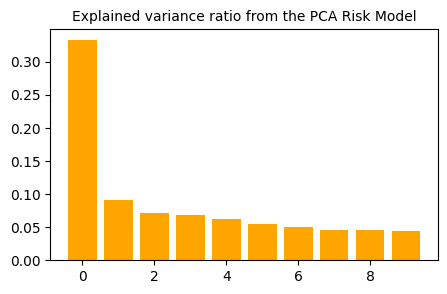

In [57]:
# visualize the percent of variance
plt.figure(figsize = (5,3))
plt.bar(np.arange(N_FACTOR_EXPOSURES), pca.explained_variance_ratio_, color = 'orange')
plt.title('Explained variance ratio from the PCA Risk Model', size = 10)

<h1 style="color:orange">Alpha Factor Evaluation</h1>

In [85]:
# calculate factor return for each factor and each ticker
factor_return_by_ticker_df = pd.DataFrame()
for ticker in test_tickers:
    ticker_exposure = factor_exposure_df.loc[ticker]
    ticker_common_return_df = factor_return_df * ticker_exposure
    ticker_common_return_df['ticker'] = ticker
    factor_return_by_ticker_df = pd.concat([factor_return_by_ticker_df, ticker_common_return_df])

factor_return_by_ticker_df = factor_return_by_ticker_df.reset_index().set_index(['date', 'ticker'])

In [59]:
factor_data_dict = dict()
for factor in factor_names:
    print(f'Formatting factor data for {factor}')
    factor_data_dict[factor] = al.utils.get_clean_factor_and_forward_returns(
        factor = factor_return_by_ticker_df[factor],
        prices = close_df_pivot[test_tickers],
        periods = [1],
        max_loss = 0.4
    )

Formatting factor data for avg_return
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for median_return
Dropped 37.4% entries from factor data: 0.0% in forward returns computation and 37.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


In [60]:
factor_return_list = []
for factor in factor_names:
    factor_return = al.performance.factor_returns(factor_data_dict[factor])
    factor_return.columns = [factor]
    factor_return_list.append(factor_return)

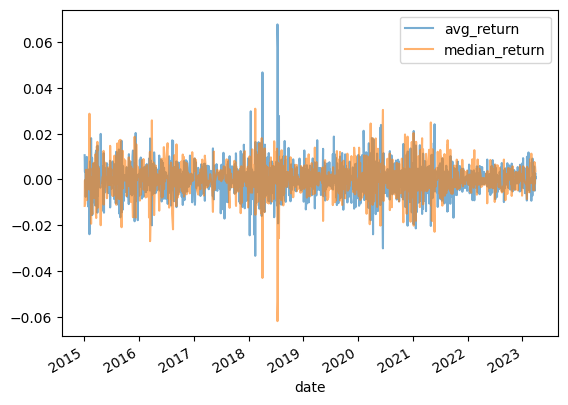

In [61]:
alpha = 0.6
factor_return_list[0]['avg_return'].plot(alpha = alpha)
factor_return_list[1]['median_return'].plot(alpha = alpha)
plt.legend()

In [62]:
# Sharpe ratio
def sharpe_ratio(df, frequency:str = "daily"):
    if frequency == "daily":
        annualization_factor = np.sqrt(252)
    elif frequency == "monthly":
        annualization_factor = np.sqrt(12)
    else:
        annualization_factor = 1
        
    sharpe_ratio = annualization_factor * (df.mean() / df.std())
    
    return sharpe_ratio


In [63]:
for factor_return in factor_return_list:
    sharpe = sharpe_ratio(factor_return)
    print(f'Sharpe Ratio for factor {factor} is {sharpe}')

Sharpe Ratio for factor median_return is avg_return    0.109926
dtype: float64
Sharpe Ratio for factor median_return is median_return    0.304715
dtype: float64


In [64]:
# information coefficient
rank_ic_df = None

for factor in factor_names:
    rank_ic = al.performance.factor_information_coefficient(factor_data_dict[factor])
    rank_ic.columns = [factor]
    rank_ic_df = rank_ic if rank_ic_df is None else rank_ic_df.merge(rank_ic, left_index = True, right_index = True)

<AxesSubplot: xlabel='date'>

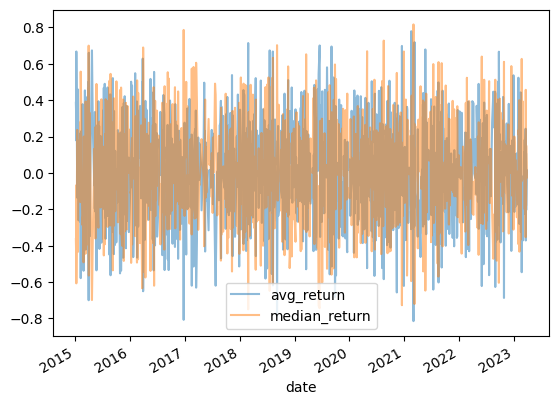

In [65]:
rank_ic_df.plot(alpha = 0.5)

In [66]:
# Portfolio Turnover (used factor rank autocorrelation as a proxy)
rank_ac_df = None

for factor in factor_names:
    rank_ac = al.performance.factor_rank_autocorrelation(factor_data_dict[factor]).to_frame()
    rank_ac.columns = [factor]
    rank_ac_df = rank_ac if rank_ac_df is None else rank_ac_df.merge(rank_ac, left_index = True, right_index = True)

<AxesSubplot: xlabel='date'>

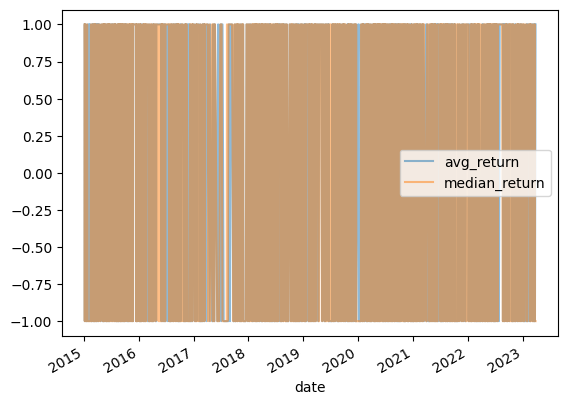

In [67]:
rank_ac_df.plot(alpha = 0.5)

In [69]:
# mean return by quantile
qt_return_df = None

for factor in factor_names:
    qt_ret, qt_std_err = al.performance.mean_return_by_quantile(factor_data_dict[factor])
    qt_ret.columns = [factor]
    qt_return_df = qt_ret if qt_return_df is None else qt_return_df.merge(qt_ret, left_index = True, right_index = True)

<AxesSubplot: xlabel='factor_quantile'>

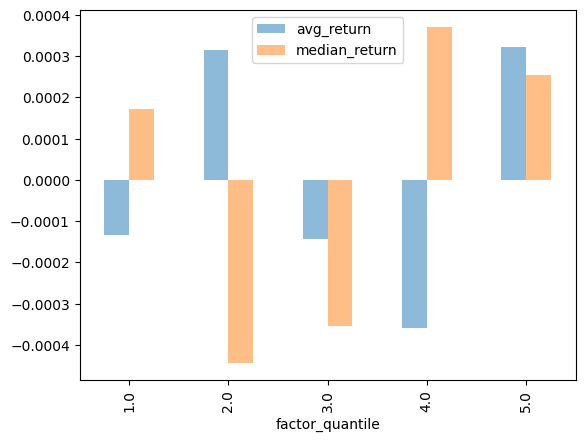

In [70]:
qt_return_df.plot(kind = 'bar', alpha = 0.5)

In [ ]:
# Transfer Coefficient
# TODO: sample alpha vector for a single time period
alpha_vector = np.random.normal(size = len(test_tickers))

# ? standardized alpha vector
alpha_vector = (alpha_vector - np.mean(alpha_vector)) / np.sum(np.abs(alpha_vector))

# ? add some noise to adjust weights
opt_weight = alpha_vector + np.random.normal(scale = 0.005, size = len(test_tickers))

opt_weight

array([-0.0006144 , -0.01582039, -0.02525602, -0.19755353,  0.02970234,
        0.08590634, -0.00087734,  0.11314482, -0.05814778,  0.00149872,
        0.15927135, -0.04616979, -0.00926241,  0.04869156, -0.07803485])

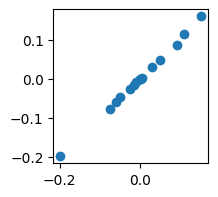

In [ ]:
# visualize alpha vector and optimized weights
plt.figure(figsize = (2,2))
plt.scatter(alpha_vector, opt_weight)

In [ ]:
def get_transfer_coefficient(alpha_vector, optimized_weights):
    transfer_coefficient, pvalue = stats.pearsonr(alpha_vector, optimized_weights)
    return transfer_coefficient

In [ ]:
transfer_coefficient = get_transfer_coefficient(alpha_vector, opt_weight)
print(f"The transfer coefficient is {transfer_coefficient:.4f}") 

The transfer coefficient is 0.9994


<h1 style="color:orange">Portfolio Optimization</h1>

In [79]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function
    x1 = weights.T.values
    x2 = (factor_betas.values @ factor_cov_matrix @ factor_betas.values.T) + idiosyncratic_var_matrix.values
    x3 = weights.values
    
    portfolio_risk = np.sqrt(x1 @ x2 @ x3)
    return portfolio_risk[0][0]

In [80]:
# TODO: simulate a portfolio risk using an equal-weight allocation
equal_weight_port = pd.DataFrame(np.repeat(1 / len(test_tickers), len(test_tickers)), test_tickers)

# * feed parameters from PCA
predict_portfolio_risk(factor_betas = rm.factor_betas_, factor_cov_matrix = rm.factor_cov_matrix_, idiosyncratic_var_matrix = rm.idiosyncratic_var_matrix_, weights = equal_weight_port)


0.17549272288730702

In [157]:
# optimizer object
class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
        return obj
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)
    

class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        obj = cvx.Minimize(-1 * alpha_vector.values.flatten() * weights)
        
        return obj
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
        constraints = [
            risk <= self.risk_cap ** 2,
            factor_betas.T * weights <= self.factor_max,
            factor_betas.T * weights >= self.factor_min,
            sum(cvx.abs(weights)) <= 1.0,
            sum(weights) == 0.0,
            weights <= self.weights_max,
            weights >= self.weights_min
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

In [172]:
alphas = factor_return_by_ticker_df.mean(axis = 1).to_frame()
alphas.columns = ['alpha_vector']
alpha_vector = alphas.loc[factor_return_by_ticker_df.index.get_level_values(0)[-1]]

# * prepare idiosyncratic variance vector
idiosyncratic_var_vector = pd.Series(np.diag(rm.idiosyncratic_var_matrix_).flatten(), index = test_tickers)

In [173]:
opt_weight = OptimalHoldings().find(alpha_vector, rm.factor_betas_, rm.factor_cov_matrix_, idiosyncratic_var_vector)

<AxesSubplot: title={'center': 'Portfolio % Holdings by Stock'}, xlabel='ticker'>

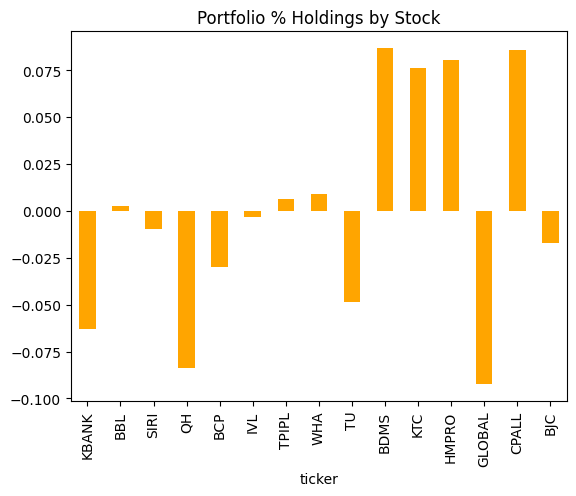

In [169]:
# Visualize the optimal holdings
opt_weight.plot.bar(legend=None, title='Portfolio % Holdings by Stock', color = 'orange')

In [171]:
# Optimizer with regularization parameter
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        normal_term = -1 * alpha_vector.values.T * weights
        regularize_term = cvx.norm(weights, 2) * self.lambda_reg
        obj = cvx.Minimize(normal_term + regularize_term)
        
        return obj

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

<AxesSubplot: title={'center': 'Portfolio % Holdings by Stock'}, xlabel='ticker'>

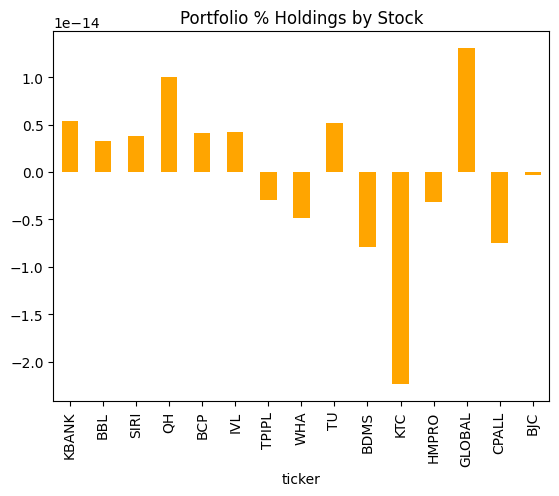

In [174]:
opt_reg_weight = OptimalHoldingsRegualization(lambda_reg = 5.0).find(alpha_vector, rm.factor_betas_, rm.factor_cov_matrix_, idiosyncratic_var_vector)

# Visualize the optimal holdings
opt_reg_weight.plot.bar(legend=None, title='Portfolio % Holdings by Stock', color = 'orange')

In [175]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        weights_star = (alpha_vector.values.flatten() - np.mean(alpha_vector.values.flatten())) / np.sum(np.abs(alpha_vector.values.flatten()))
        obj = cvx.Minimize(cvx.norm(weights - weights_star, 2))
        
        return obj

<AxesSubplot: title={'center': 'Portfolio % Holdings by Stock'}, xlabel='ticker'>

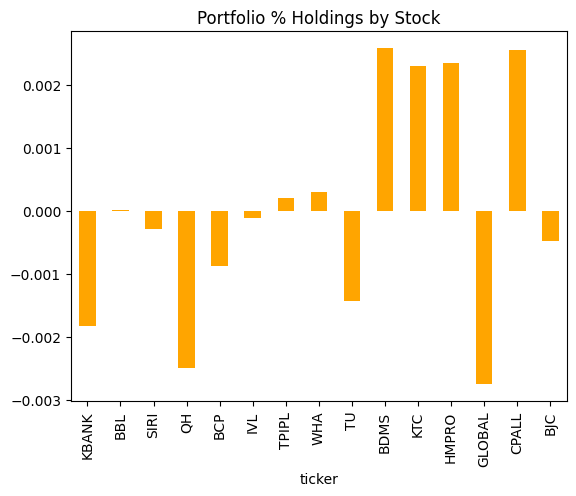

In [176]:
opt_strict_weight = OptimalHoldingsStrictFactor(weights_max = 0.02, weights_min = -0.02, risk_cap = 0.0015, factor_max = 0.015, factor_min = -0.015) \
                        .find(alpha_vector, rm.factor_betas_, rm.factor_cov_matrix_, idiosyncratic_var_vector)

# Visualize the optimal holdings
opt_strict_weight.plot.bar(legend=None, title='Portfolio % Holdings by Stock', color = 'orange')